## Analysis of feature selection results; single-cancer holdouts

For our "cross-cancer" feature selection method, we expect it to provide a performance improvement (or at least to be more resistant to drops in performance) "across" cancer types; or in other words, when a single cancer type is held out and a model is trained on other (potentially related, but not exactly the same) cancer types from TCGA.

This script visualizes results from 3 types of data splitting experiments, implemented in `02_cancer_type_classification/run_cancer_type_classification.py`:

* "Train single cancer": train and test on the same individual cancer type
* "Train pan-cancer": train on the test cancer type + all other valid TCGA cancer types
* "Train all other cancers": train on all other valid TCGA cancer types (without the test cancer type in the training set)

In each case, we're splitting the test cancer type using 4-fold cross-validation (so we're using 75% of the data from the test cancer type for evaluation). For the single cancer and pan-cancer cases the remaining 25% of the data from the test cancer type is part of the training set, and for the "all other cancers" case we don't use the other 25% of the data at all, but we still evaluate on the same 75% (not the whole dataset) so that results will be comparable.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot as up
from venn import generate_petal_labels

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
# analysis of results generated by script:
# 02_cancer_type_classification/run_stratified_classification.py
# (with varying feature_selection parameters)

single_cancer_dir = os.path.join('results', 'univariate_fs', 'single_cancer')
pancancer_dir = os.path.join('results', 'univariate_fs', 'pancancer')
pancancer_only_dir = os.path.join('results', 'univariate_fs', 'pancancer_only')
large_n_dims = 1000
small_n_dims = 250

### Load results

We load the results of the single cancer, pan-cancer, and "pan-cancer only" (aka "all other cancers") experiments here.

In [3]:
single_cancer_df = au.load_prediction_results_fs(
    single_cancer_dir, cfg.fs_methods
)
single_cancer_df['train_set'] = 'single_cancer'

single_cancer_df.loc[
    (single_cancer_df.fs_method == 'mad') & (single_cancer_df.n_dims == small_n_dims),
    'fs_method'
] = 'mad_{}'.format(small_n_dims)
single_cancer_df.loc[
    (single_cancer_df.fs_method == 'mad') & (single_cancer_df.n_dims == large_n_dims),
    'fs_method'
] = 'mad_{}'.format(large_n_dims)

print(np.unique(single_cancer_df.seed))
print(single_cancer_df.shape)
single_cancer_df.head()

[ 1 42]
(12816, 11)


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,fs_method,n_dims,train_set
0,0.82797,0.88066,TP53,PAAD,signal,42,train,0,mad_250,250,single_cancer
1,0.64167,0.87810,TP53,PAAD,signal,42,test,0,mad_250,250,single_cancer
2,0.72233,0.80906,TP53,PAAD,signal,42,cv,0,mad_250,250,single_cancer
3,0.85531,0.92739,TP53,PAAD,signal,42,train,1,mad_250,250,single_cancer
4,0.66957,0.76241,TP53,PAAD,signal,42,test,1,mad_250,250,single_cancer


In [4]:
pancancer_df = au.load_prediction_results_fs(
    pancancer_dir, cfg.fs_methods
)
pancancer_df['train_set'] = 'pancancer'

pancancer_df.loc[
    (pancancer_df.fs_method == 'mad') & (pancancer_df.n_dims == small_n_dims),
    'fs_method'
] = 'mad_{}'.format(small_n_dims)
pancancer_df.loc[
    (pancancer_df.fs_method == 'mad') & (pancancer_df.n_dims == large_n_dims),
    'fs_method'
] = 'mad_{}'.format(large_n_dims)

print(np.unique(pancancer_df.seed))
print(pancancer_df.shape)
pancancer_df.head()

[ 1 42]
(12816, 11)


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,fs_method,n_dims,train_set
0,0.90235,0.88124,TP53,PAAD,signal,42,train,0,mad_250,250,pancancer
1,0.95000,0.98709,TP53,PAAD,signal,42,test,0,mad_250,250,pancancer
2,0.85635,0.82836,TP53,PAAD,signal,42,cv,0,mad_250,250,pancancer
3,0.90357,0.88546,TP53,PAAD,signal,42,train,1,mad_250,250,pancancer
4,0.58551,0.73804,TP53,PAAD,signal,42,test,1,mad_250,250,pancancer


In [5]:
pancancer_only_df = au.load_prediction_results_fs(
    pancancer_only_dir, cfg.fs_methods
)
pancancer_only_df['train_set'] = 'pancancer_only'

pancancer_only_df.loc[
    (pancancer_only_df.fs_method == 'mad') & (pancancer_only_df.n_dims == small_n_dims),
    'fs_method'
] = 'mad_{}'.format(small_n_dims)
pancancer_only_df.loc[
    (pancancer_only_df.fs_method == 'mad') & (pancancer_only_df.n_dims == large_n_dims),
    'fs_method'
] = 'mad_{}'.format(large_n_dims)

print(np.unique(pancancer_only_df.seed))
print(pancancer_only_df.shape)
pancancer_only_df.head()

[ 1 42]
(12816, 11)


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,fs_method,n_dims,train_set
0,0.90111,0.87966,TP53,PAAD,signal,42,train,0,mad_250,250,pancancer_only
1,0.94167,0.98511,TP53,PAAD,signal,42,test,0,mad_250,250,pancancer_only
2,0.85117,0.82621,TP53,PAAD,signal,42,cv,0,mad_250,250,pancancer_only
3,0.90111,0.87966,TP53,PAAD,signal,42,train,1,mad_250,250,pancancer_only
4,0.59710,0.72623,TP53,PAAD,signal,42,test,1,mad_250,250,pancancer_only


In [6]:
# get difference between true and shuffled models, split by
# feature selection method and holdout cancer type
def compare_from_experiment(experiment_df):
    compare_df = []
    for fs_method in experiment_df.fs_method.unique():
        for holdout_cancer_type in experiment_df.holdout_cancer_type.unique():
            compare_df.append(
                au.compare_control_ind(
                    experiment_df[
                        (experiment_df.fs_method == fs_method) &
                        (experiment_df.holdout_cancer_type == holdout_cancer_type)
                    ], metric='aupr', verbose=True)
                  .assign(fs_method=fs_method,
                          holdout_cancer_type=holdout_cancer_type)
            )
    return pd.concat(compare_df)
    
single_cancer_compare_df = compare_from_experiment(single_cancer_df)
pancancer_compare_df = compare_from_experiment(pancancer_df)
pancancer_only_compare_df = compare_from_experiment(pancancer_only_df)

print(single_cancer_compare_df.shape,
      pancancer_compare_df.shape,
      pancancer_only_compare_df.shape)

(2136, 6) (2136, 6) (2136, 6)


In [7]:
single_cancer_compare_df.head()

,identifier,seed,fold,delta_aupr,fs_method,holdout_cancer_type
0,TP53,42,0,0.03254,mad_250,PAAD
1,TP53,42,1,0.20629,mad_250,PAAD
2,TP53,42,2,0.18808,mad_250,PAAD
3,TP53,42,3,0.22626,mad_250,PAAD
4,TP53,1,0,0.05957,mad_250,PAAD


### Plot average performance across cancer types

In [8]:
gene = 'EGFR'

# if we want to filter to certain cancer types we can set that here
# cancer_types = None applies no filtering (i.e. all cancer types where
# results files exist)
cancer_types = None

# these are the cancer types we use for TP53 (visualizing all of them gets a bit large/noisy)
# cancer_types = [
#     'BLCA',
#     'BRCA',
#     'COAD',
#     'LGG',
#     'LUAD',
#     'SARC',
#     'SKCM',
#     'STAD',
#     'UCEC'
# ]

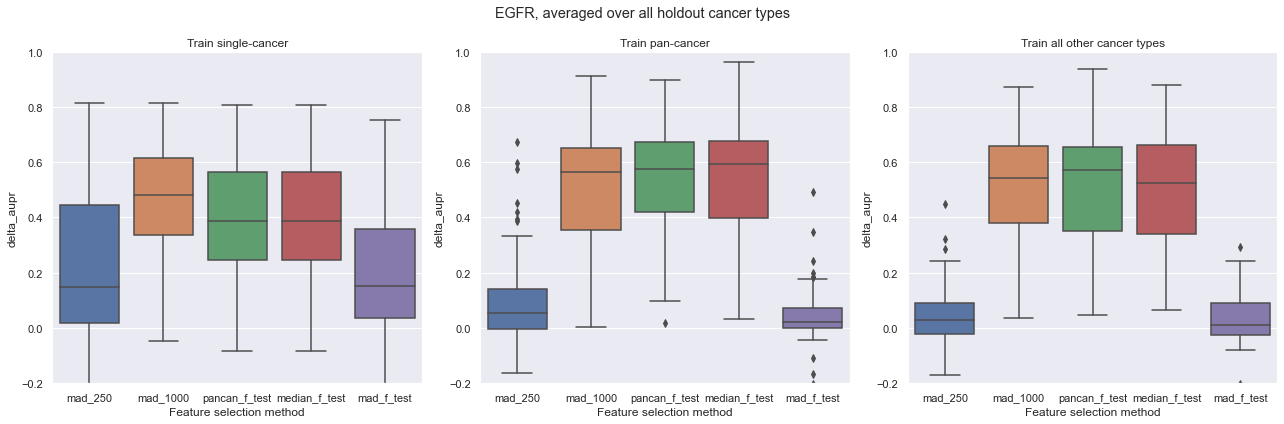

In [9]:
sns.set({'figure.figsize': (18, 6)})
sns.set_context('notebook')

fig, axarr = plt.subplots(1, 3)

dfs_to_plot = [
    single_cancer_compare_df,
    pancancer_compare_df,
    pancancer_only_compare_df
]

names_to_plot = [
    'Train single-cancer',
    'Train pan-cancer',
    'Train all other cancer types'
]

fs_method_order = [
    'mad_250',
    'mad_1000',
    'pancan_f_test',
    'median_f_test',
    'mad_f_test'
]


for ix, compare_df in enumerate(dfs_to_plot):
    ax = axarr[ix]
    # averaged over cancer types
    if cancer_types is None:
        plot_df = compare_df[(compare_df.identifier == gene)]
    else:
        plot_df = compare_df[(compare_df.identifier == gene) &
                             (compare_df.holdout_cancer_type.isin(cancer_types))]
    sns.boxplot(data=plot_df, x='fs_method', y='delta_aupr',
                order=fs_method_order, ax=ax)
    ax.set_title(names_to_plot[ix])
    ax.set_xlabel('Feature selection method')
    ax.set_ylim(-0.2, 1)
    
plt.suptitle('{}, averaged over all holdout cancer types'.format(gene))
plt.tight_layout()

In [10]:
# these are "non-carcinoma" cancer types in TCGA
# we anticipate that these will be the hardest to transfer models to (since
# most of TCGA, and thus most of our training set, is generally carcinomas),
# so it's also valuable to look at results filtered only to these
non_carcinomas = [
    'GBM',
    'LGG',
    'SARC',
    'SKCM',
    'TGCT'
]

['GBM' 'LGG']


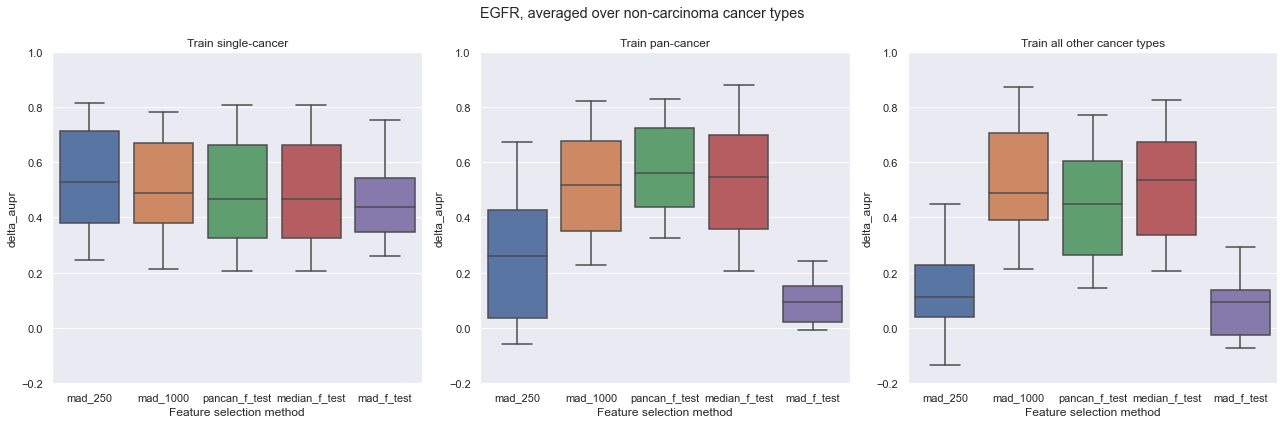

In [11]:
sns.set({'figure.figsize': (18, 6)})
sns.set_context('notebook')

fig, axarr = plt.subplots(1, 3)

dfs_to_plot = [
    single_cancer_compare_df,
    pancancer_compare_df,
    pancancer_only_compare_df
]

names_to_plot = [
    'Train single-cancer',
    'Train pan-cancer',
    'Train all other cancer types'
]


for ix, compare_df in enumerate(dfs_to_plot):
    ax = axarr[ix]
    # averaged over non-carcinoma cancer types
    plot_df = compare_df[(compare_df.identifier == gene) &
                         (compare_df.holdout_cancer_type.isin(non_carcinomas))]
    if ix == 0:
        # look at which cancer types are actually present in dataset
        print(plot_df.holdout_cancer_type.unique(), file=sys.stderr)
    sns.boxplot(data=plot_df, x='fs_method', y='delta_aupr',
                order=fs_method_order, ax=ax)
    ax.set_title(names_to_plot[ix])
    ax.set_xlabel('Feature selection method')
    ax.set_ylim(-0.2, 1)
    
plt.suptitle('{}, averaged over non-carcinoma cancer types'.format(gene))
plt.tight_layout()

### Plot performance broken down by cancer type

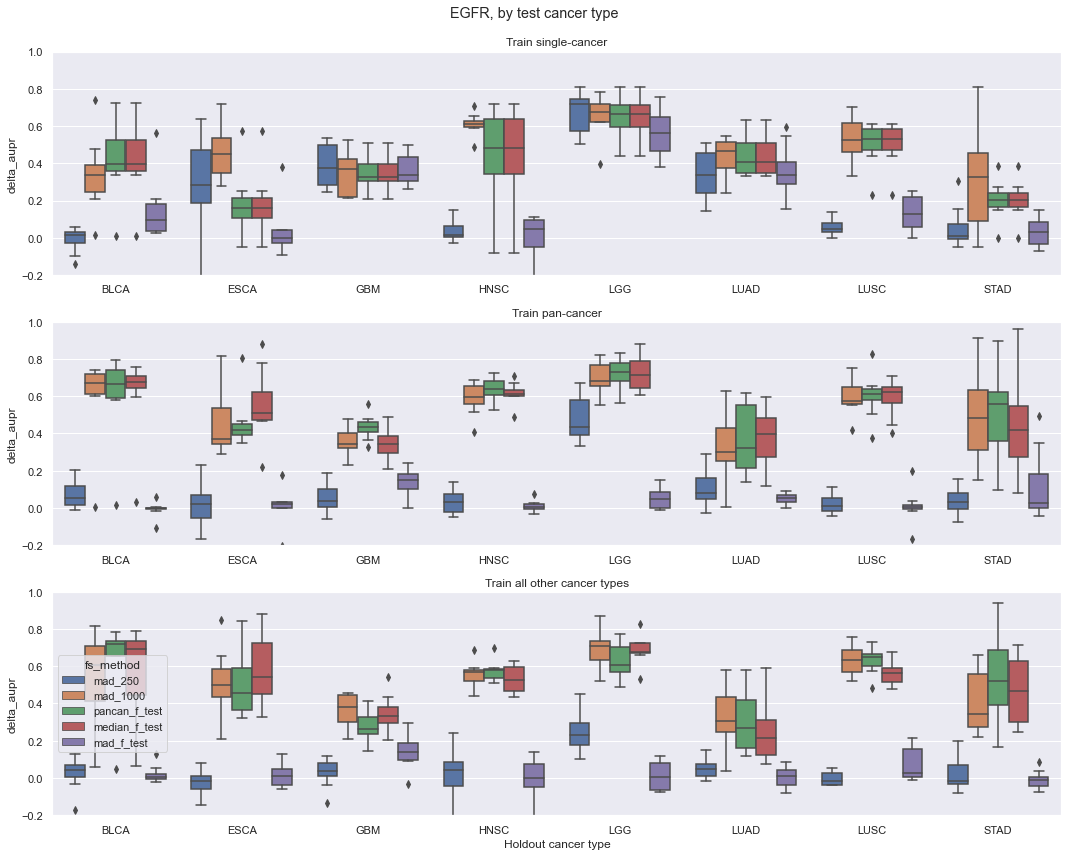

In [12]:
sns.set({'figure.figsize': (15, 12)})
sns.set_context('notebook')

fig, axarr = plt.subplots(3, 1)

dfs_to_plot = [
    single_cancer_compare_df,
    pancancer_compare_df,
    pancancer_only_compare_df
]

names_to_plot = [
    'Train single-cancer',
    'Train pan-cancer',
    'Train all other cancer types'
]

# split individual cancer types
for ix, to_plot_df in enumerate(dfs_to_plot):
    ax = axarr[ix]
    if cancer_types is None:
        plot_df = (
            to_plot_df[(to_plot_df.identifier == gene)]
              .sort_values(by='holdout_cancer_type')
        )
    else:
        plot_df = (
            to_plot_df[(to_plot_df.identifier == gene) &
                       (to_plot_df.holdout_cancer_type.isin(cancer_types))]
              .sort_values(by='holdout_cancer_type')
        )
    sns.boxplot(data=plot_df, x='holdout_cancer_type', 
                y='delta_aupr', hue='fs_method', 
                hue_order=fs_method_order, ax=ax)
    ax.set_title(names_to_plot[ix])
    if ix == len(dfs_to_plot) - 1:
        ax.set_xlabel('Holdout cancer type')
    else:
        ax.set_xlabel('')
        ax.get_legend().remove()
    ax.set_ylim(-0.2, 1)
    
plt.suptitle('{}, by test cancer type'.format(gene), y=0.99)
plt.tight_layout()

### Plot performance broken down by cancer type and test set

This will show trends for each data partition: i.e. is improved performance for a particular feature selection method driven by a large increase in performance for one or two data partitions and no change for the others, or a small increase in performance across all the data partitions?

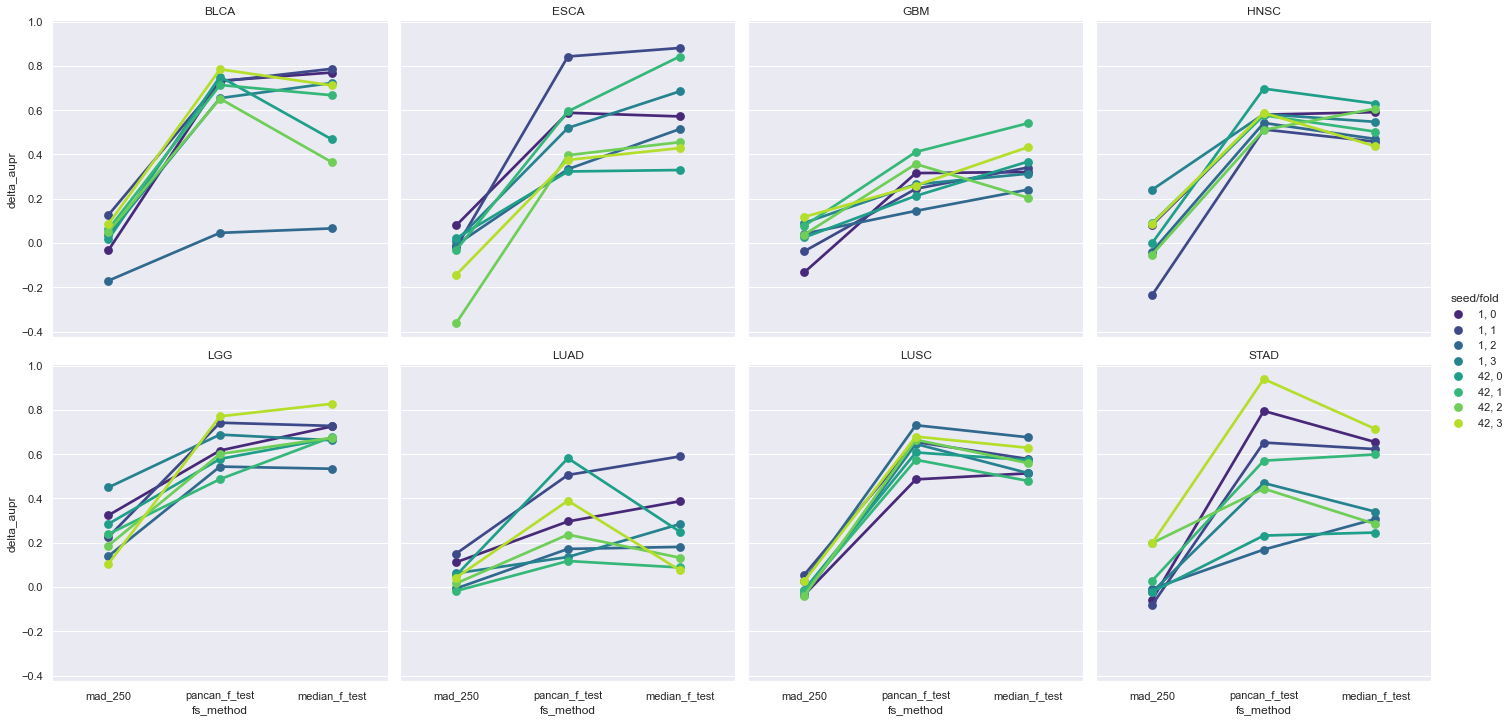

In [13]:
sns.set({'figure.figsize': (15, 6)})
sns.set_context('notebook')

plot_fs_methods = [
    'mad_250',
    'pancan_f_test',
    'median_f_test'
]

if cancer_types is None:
    plot_df = (
        pancancer_only_compare_df[
            (pancancer_only_compare_df.identifier == gene) &
            (pancancer_only_compare_df.fs_method.isin(plot_fs_methods))
        ].sort_values(by='holdout_cancer_type')
    ).sort_values(by=['seed', 'fold'])
else:
    plot_df = (
        pancancer_only_compare_df[
            (pancancer_only_compare_df.identifier == gene) &
            (pancancer_only_compare_df.holdout_cancer_type.isin(cancer_types)) &
            (pancancer_only_compare_df.fs_method.isin(plot_fs_methods))
        ].sort_values(by='holdout_cancer_type')
    ).sort_values(by=['seed', 'fold'])
plot_df['seed/fold'] = plot_df.seed.astype(str) + ', ' + plot_df.fold.astype(str)

g = sns.catplot(
    data=plot_df, x='fs_method', y='delta_aupr', col='holdout_cancer_type',
    hue='seed/fold', kind='point', col_wrap=4, order=plot_fs_methods,
    palette='viridis'
)
g.set_titles(col_template='{col_name}')

Particularly for EGFR and TP53, we do tend to see that selecting features by a metric that aggregates across cancer types (`median_f_test`) improves performance particularly on the non-carcinomas, relative to other methods that can be driven by strong signal/correlation in a single cancer type (`mad`, `pancan_f_test`). This is the case where we're expecting `median_f_test` to provide an improvement.

For PIK3CA we don't really see this as much when LGG (the only valid non-carcinoma) is held out; `pancan_f_test` still outperforms `median_f_test` in the "train all other" case. Predicting PIK3CA mutation status across cancer types seems to be a more difficult problem in general (lower average AUPR values); maybe there just isn't enough pan-cancer signal to make modeling across cancer types work well.